# Image Super-resolution via Convolutional Neural Network
 
Image super-resolution aims to recover high-reosolution images from low-resolution input images.

In this notebook, I create supre-resolution convolutional neural network (SRCNN) mainly follow the structure proposed by an [IEEE paper](https:////ieeexplore.ieee.org/abstract/document/7115171?casa_token=Gn-JWxWU7DsAAAAA:jiqMK8z75oLS24BWG5eLuJ6gd-BQtbKVrxziuLAvsz8DsAk0ddc50Obl3J8mm8WrIV6m8NLWbFk).

Images from [DIV2K dataset](https://data.vision.ee.ethz.ch/cvl/DIV2K/) are used to construct training and validation datasets. 

Model performance is measured using Peak Signal-to-Noise Ratio (PSNR). 


## Google Colabl Setup
Set COLAB = True if running is Google Colab

Set GPU = True if running on GPU

In [6]:
COLAB = False
GPU = False

# Setup for Colab
if COLAB:
    # Connect Google Drive
    from google.colab import drive
    drive.mount("/content/gdrive")
    # Prefix for Google Drifve Directory
    prefix = '/content/gdrive/MyDrive/COGS-118B-Final-Project/'

# Setup for GPU Runtime
if GPU:
    # Check GPU
    import tensorflow as tf
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

    # Logging GPU placement
    #tf.debugging.set_log_device_placement(True)

In [2]:
# Comment out the next 2 line to install missing packages for Colab
%%capture
!pip install tensorflow_io

## Download DIV2K Datasets

In [1]:
pwd

'/Users/liyang/new_118B_repo'

In [2]:
mkdir DIV2K

In [3]:
cd DIV2K

/Users/liyang/new_118B_repo/DIV2K


In [4]:
%%capture

download_datasets = True


if download_datasets:
    # download train_input: train_LR_x8
    !wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip"
    # download train_label: train_LR_bicubic
    !wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip"
    # download valid_input: valid_LR_x8
    !wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip"
    # download valid_label: valid_LR_bicubic_X4
    !wget "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip"
    # unzip files
    !unzip "DIV2K_train_LR_x8.zip"
    !unzip "DIV2K_train_LR_bicubic_X4.zip"
    !unzip "DIV2K_valid_LR_x8.zip"
    !unzip "DIV2K_valid_LR_bicubic_X4.zip"
    # remove zip files
    !rm "DIV2K_train_LR_x8.zip"
    !rm "DIV2K_train_LR_bicubic_X4.zip"
    !rm "DIV2K_valid_LR_x8.zip"
    !rm "DIV2K_valid_LR_bicubic_X4.zip"


In [5]:
cd ..

/Users/liyang/new_118B_repo


## Setup

In [7]:
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import numpy as np
import PIL
import PIL.Image
import time

from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from PIL import Image

In [8]:
print("Expected tf version: \n'2.3.1'\n")
print("Actual tf version:")
tf.__version__

Expected tf version: 
'2.3.1'

Actual tf version:


'2.3.1'

## Build and Compile the SRCNN Model

In [9]:
# Define number of filters and filter size
n1 = 128 # number of filters for 1st layer
n2 = 64 # number of filters for 2nd and 3rd layer
f1 = 11  # filter size for 1st layer
f2 = 5  # filter size for 2nd layer
f3 = 7  # filter size for 3rd layer
c = 3   # number of channels in the image

# Define input size
input_shape = (None,None,3)
# Define strides for filters
strides = 1
# Define Weights Initializer (Xavier initialization)
initializer = tf.keras.initializers.glorot_normal()

# Create the model
model = models.Sequential()
from functools import partial
activation= partial(tf.nn.leaky_relu, alpha=0.01)
# Add 1st layer: Patch Extraction and Representation
model.add(layers.Conv2D(filters=n1, kernel_size=f1, activation=activation, kernel_initializer=initializer, strides = strides, padding='same', input_shape = input_shape))
# Add 2nd layer: Non-Linear Mapping
model.add(layers.Conv2D(filters=n2, kernel_size=f2, activation=activation, kernel_initializer=initializer, strides = strides, padding='same'))
# Add 3rd layer: Reconstruction
model.add(layers.Conv2D(filters=c, kernel_size=f3, activation=activation, kernel_initializer=initializer, strides = strides, padding='same')) 
model.summary()

# Define Metrics (PSNR)
def call_PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val = 255)

# Define Adam Optimizer
adam = Adam(lr=0.0003)

# Compile model
model.compile(optimizer = adam, loss = tf.keras.losses.MeanSquaredError(), metrics = [call_PSNR])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   46592     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     9411      
Total params: 260,867
Trainable params: 260,867
Non-trainable params: 0
_________________________________________________________________


## Define Functions to Create Datasets


In [10]:
def generate_data_set(path, start_image_index, number_of_images, image_suffix, extension, target_size):
    
    result_array_list = list()
    portrait_size = (target_size[1], target_size[0])
    # loop over each images in the directory
    for i in range (0,number_of_images):
        current_image_index = start_image_index + i
        current_file_name = path + '/' + str(current_image_index).zfill(4) +image_suffix + extension
        # pre load image to decide its size, if h > w, rotate it in later steps
        current_image = tf.keras.preprocessing.image.load_img(current_file_name, target_size = None)
        # skip portrait images
        if (current_image.height > current_image.width):
            continue
        # load current image to desired size if its not a portrait image
        current_image = tf.keras.preprocessing.image.load_img(current_file_name, target_size = target_size, interpolation = 'bicubic')
        # convert current image to ndarray
        current_image_array = tf.keras.preprocessing.image.img_to_array(current_image)
        # append current image (as an ndarray) to the list
        result_array_list.append(current_image_array)
    # create an 4D array using elements in the list and return it
    return np.array(result_array_list)

## Create Training and Validation Datasets
High-resolution images: use images in DIV2K_train_LR_bicubic/X4 (typical shape: 350 x 510)

Low-resolution images:  use images in DIV2K_train_LR_x8

Define target shape as (350,510)

In [11]:
# Create training and validation datasets 

# Define path
train_input_dir = 'DIV2K/DIV2K_train_LR_x8'
train_label_dir = 'DIV2K/DIV2K_train_LR_bicubic/X4'
valid_input_dir = 'DIV2K/DIV2K_valid_LR_x8'
valid_label_dir = 'DIV2K/DIV2K_valid_LR_bicubic/X4'
if COLAB:
    train_input_dir = prefix + train_input_dir
    train_label_dir = prefix + train_label_dir
    valid_input_dir = prefix + valid_input_dir
    valid_label_dir = prefix + valid_label_dir

# Define start_image_index
train_input_start_image_index = 1
valid_input_start_image_index = 801
train_label_start_image_index = train_input_start_image_index
valid_label_start_image_index = valid_input_start_image_index

# Define number_of_images
train_input_number_of_images = 5 
valid_input_number_of_images = 1
train_label_number_of_images = train_input_number_of_images
valid_label_number_of_images = valid_input_number_of_images

# Define image_suffix
train_input_suffix = 'x8'
train_label_suffix = 'x4'
valid_input_suffix = train_input_suffix
valid_label_suffix = train_label_suffix

# Define extension
train_input_extension = '.png'
train_label_extension = train_input_extension
valid_input_extension = train_input_extension
valid_label_extension = train_input_extension

# Define target_size
target_size = (350,510)  #Typical Size of images : 350 x 510

# Create train_input
print("Creating train_input:")
train_input = generate_data_set(train_input_dir, train_input_start_image_index, train_input_number_of_images, train_input_suffix, train_input_extension, target_size)
print(train_input.shape)
print()
# Create train_label
print("Creating train_label:")
train_label = generate_data_set(train_label_dir, train_label_start_image_index, train_label_number_of_images, train_label_suffix, train_label_extension, target_size)
print(train_label.shape)
print()
# Create valid_input
print("Creating valid_input:")
valid_input = generate_data_set(valid_input_dir, valid_input_start_image_index, valid_input_number_of_images, valid_input_suffix, valid_input_extension, target_size)
print(valid_input.shape)
print()
# Create valid_label
print("Creating valid_label:")
valid_label = generate_data_set(valid_label_dir, valid_label_start_image_index, valid_label_number_of_images, valid_label_suffix, valid_label_extension, target_size)
print(valid_label.shape)
print()
# Combine input and label into dataset
print("Combining input and label into dataset")
train_dataset = tf.data.Dataset.from_tensor_slices((train_input,train_label))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_input,valid_label))
BATCH_SIZE = 1
train_dataset = train_dataset.batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)
print("Done")

Creating train_input:
(4, 350, 510, 3)

Creating train_label:
(4, 350, 510, 3)

Creating valid_input:
(1, 350, 510, 3)

Creating valid_label:
(1, 350, 510, 3)

Combining input and label into dataset
Done


## Train the Model

In [14]:
epochs = 1
verbose = 1
model.fit(train_dataset , epochs = epochs, validation_data = valid_dataset, verbose = verbose)

4/4 [==============================] - 12s 3s/step - loss: 1334.1566 - call_PSNR: 17.5403 - val_loss: 1132.4249 - val_call_PSNR: 17.5907


## Visualize Model Performace for One Image

In [15]:
# Define Functions to visualize model performance

def load_image_as_array(current_file_name, target_size):
    current_image = tf.keras.preprocessing.image.load_img(current_file_name, target_size = target_size)
    # convert current image to ndarray
    current_image_array = tf.keras.preprocessing.image.img_to_array(current_image)
    return current_image_array

def view_model_performance(HR_image_name, LR_image_name):
    # load the high-resolution label image
    HR_image_array = load_image_as_array(HR_image_name, target_size)
    HR_image_array = np.expand_dims(HR_image_array, 0)
    HR_image = tf.keras.preprocessing.image.array_to_img(HR_image_array[0])
    # Load the low-resolution input image
    LR_image_array = load_image_as_array(LR_image_name, target_size)
    LR_image_array = np.expand_dims(LR_image_array, 0)
    LR_image = tf.keras.preprocessing.image.array_to_img(LR_image_array[0])
    # Create the SRCNN recoverd image
    predict_result = model.predict(LR_image_array)
    result_image = predict_result[0]
    recovered_image = tf.keras.preprocessing.image.array_to_img(result_image)
    # Display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(35, 51))
    axs[0].imshow(HR_image)
    axs[0].set_title('High-resolution')
    axs[1].imshow(LR_image)
    axs[1].set_title('Low-resolution')
    axs[2].imshow(recovered_image)
    axs[2].set_title('SRCNN Recovered')
    return (HR_image_array, LR_image_array, result_image)

def calculate_image_array_PSNR(high_resolution_image_array, low_resolution_image_array):
    return call_PSNR(high_resolution_image_array, low_resolution_image_array).numpy()[0]

In [16]:
# Define functions to print full size images
def print_original(result_image_arrays):
    print("Original: ")
    return tf.keras.preprocessing.image.array_to_img(result_image_arrays[0][0])
def print_degraded(result_image_arrays):
    print("Degraded: ")
    return tf.keras.preprocessing.image.array_to_img(result_image_arrays[1][0])
def print_recovered(result_image_arrays):
    print("SRCNN Recovered: ")
    return tf.keras.preprocessing.image.array_to_img(result_image_arrays[2])

Low-resolution:
PSNR:  26.36178

SRCNN Recovered:
PSNR:  17.798122


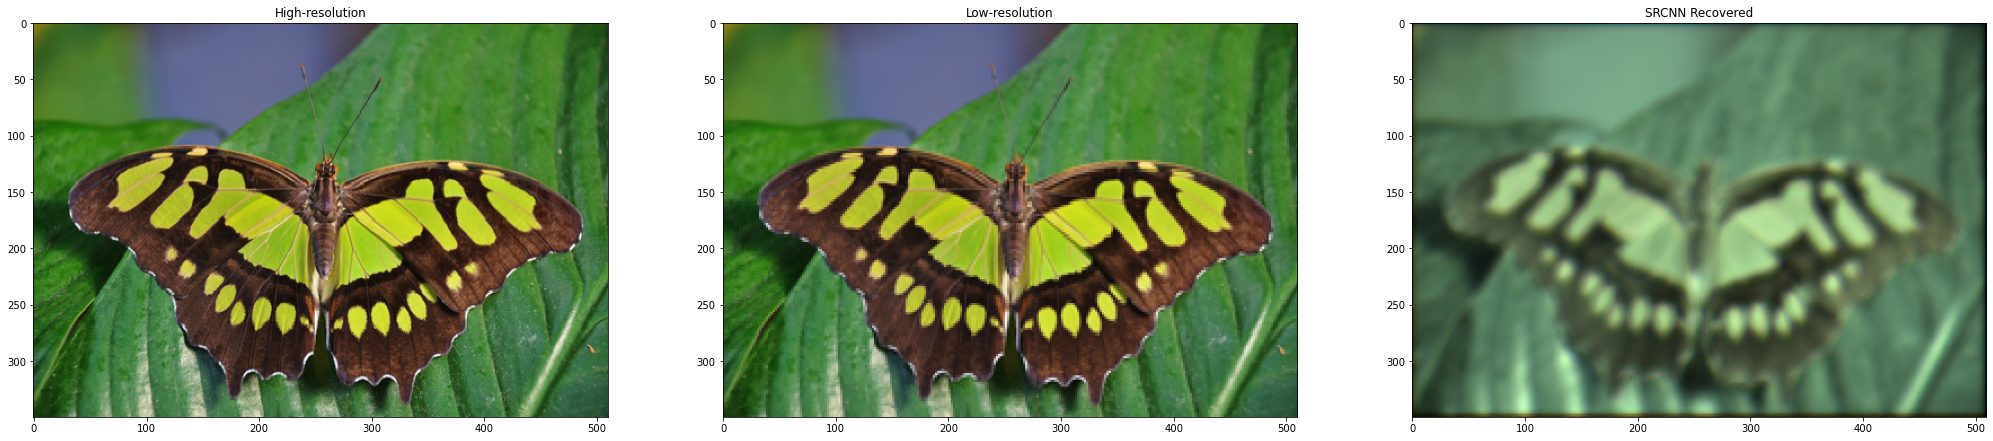

In [17]:
# Display images as subplots (Butterfly)

high_resolution_image_name = 'DIV2K/DIV2K_valid_LR_bicubic/X4/0829x4.png'
low_resolution_image_name = 'DIV2K/DIV2K_valid_LR_x8/0829x8.png'
if COLAB:
    low_resolution_image_name = prefix + low_resolution_image_name
    high_resolution_image_name = prefix + high_resolution_image_name

result_image_arrays = view_model_performance(high_resolution_image_name, low_resolution_image_name)
print("Low-resolution:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[1]))
print()
print("SRCNN Recovered:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[2]))

Low-resolution:
PSNR:  25.118765

SRCNN Recovered:
PSNR:  18.90525


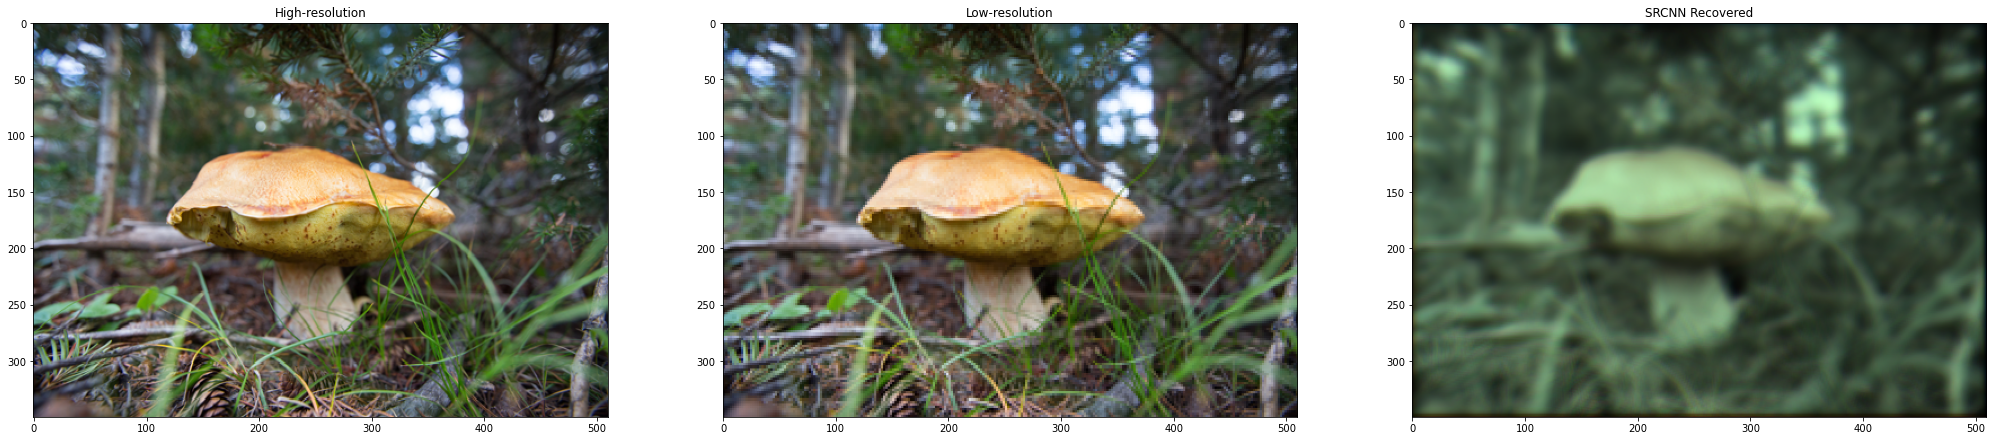

In [18]:
# Display images as subplots (Mushroom)

high_resolution_image_name = 'DIV2K/DIV2K_valid_LR_bicubic/X4/0815x4.png'
low_resolution_image_name = 'DIV2K/DIV2K_valid_LR_x8/0815x8.png'
if COLAB:
    low_resolution_image_name = prefix + low_resolution_image_name
    high_resolution_image_name = prefix + high_resolution_image_name

result_image_arrays = view_model_performance(high_resolution_image_name, low_resolution_image_name)
print("Low-resolution:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[1]))
print()
print("SRCNN Recovered:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[2]))

Low-resolution:
PSNR:  26.699762

SRCNN Recovered:
PSNR:  17.936428


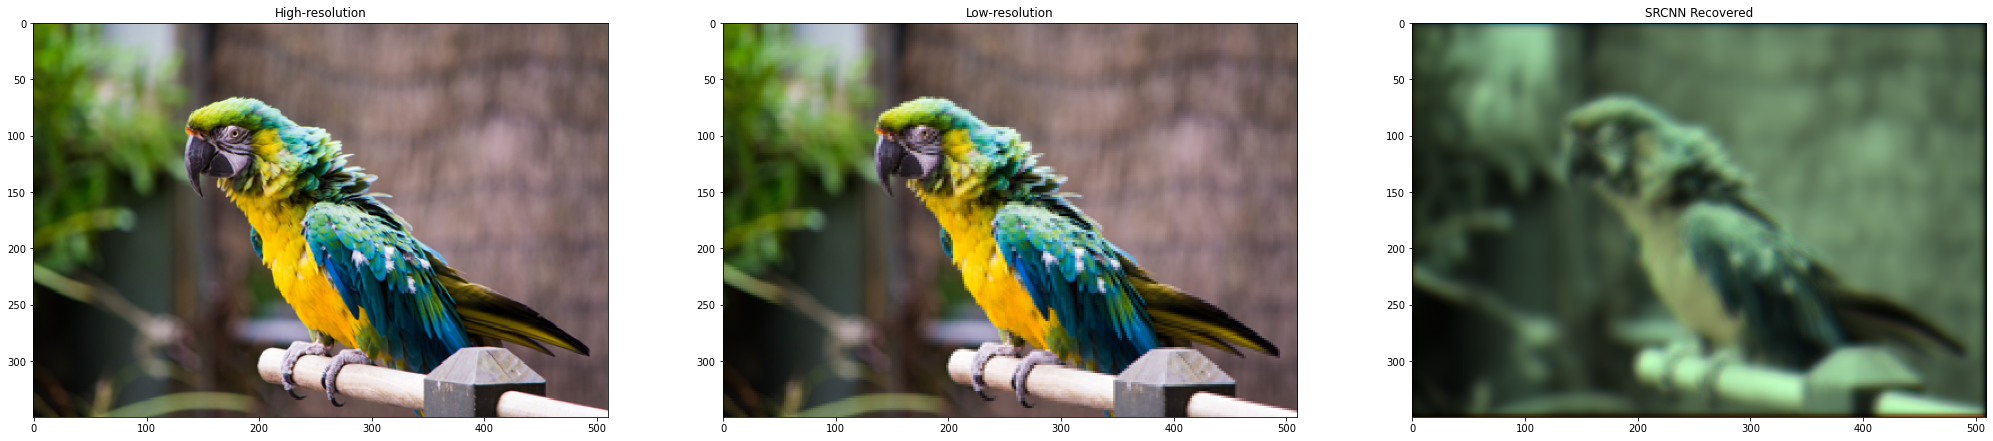

In [19]:
# Display images as subplots (Bird)

high_resolution_image_name = 'DIV2K/DIV2K_valid_LR_bicubic/X4/0886x4.png'
low_resolution_image_name = 'DIV2K/DIV2K_valid_LR_x8/0886x8.png'
if COLAB:
    low_resolution_image_name = prefix + low_resolution_image_name
    high_resolution_image_name = prefix + high_resolution_image_name

result_image_arrays = view_model_performance(high_resolution_image_name, low_resolution_image_name)
print("Low-resolution:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[1]))
print()
print("SRCNN Recovered:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[2]))

Low-resolution:
PSNR:  17.91802

SRCNN Recovered:
PSNR:  13.309505


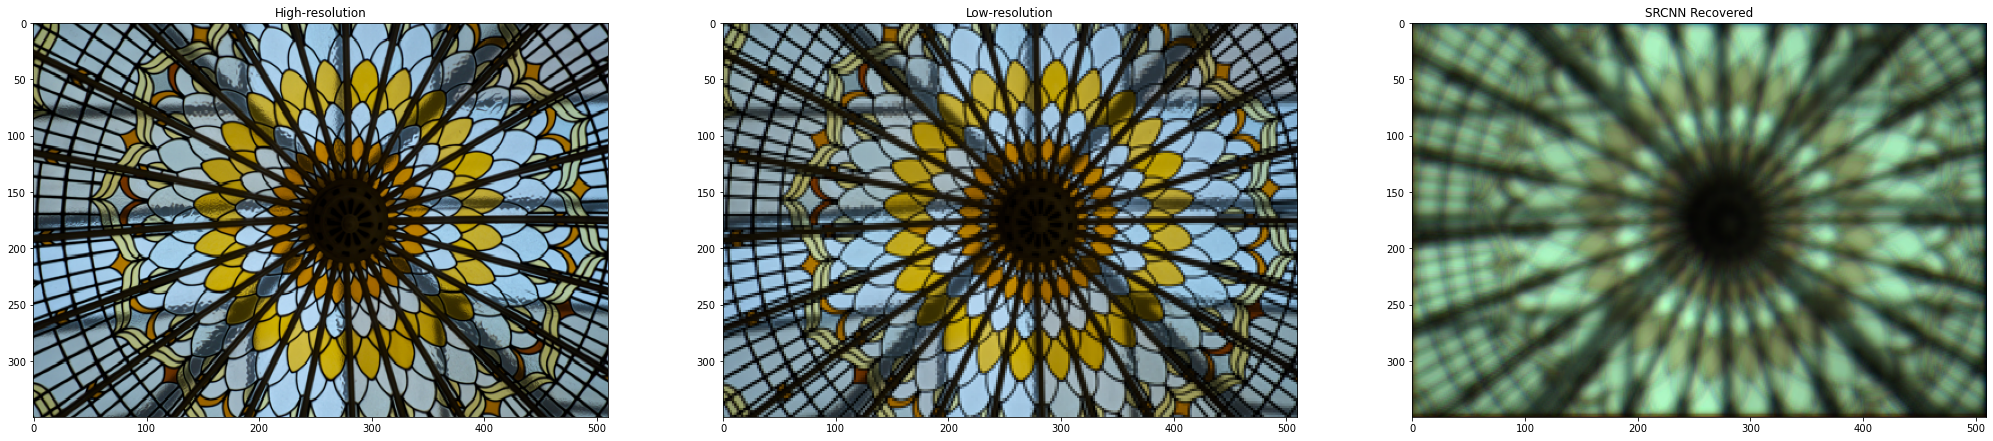

In [20]:
# Display images as subplots (?)

high_resolution_image_name = 'DIV2K/DIV2K_valid_LR_bicubic/X4/0821x4.png'
low_resolution_image_name = 'DIV2K/DIV2K_valid_LR_x8/0821x8.png'
if COLAB:
    low_resolution_image_name = prefix + low_resolution_image_name
    high_resolution_image_name = prefix + high_resolution_image_name

result_image_arrays = view_model_performance(high_resolution_image_name, low_resolution_image_name)
print("Low-resolution:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[1]))
print()
print("SRCNN Recovered:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[2]))

Low-resolution:
PSNR:  26.534977

SRCNN Recovered:
PSNR:  13.443352


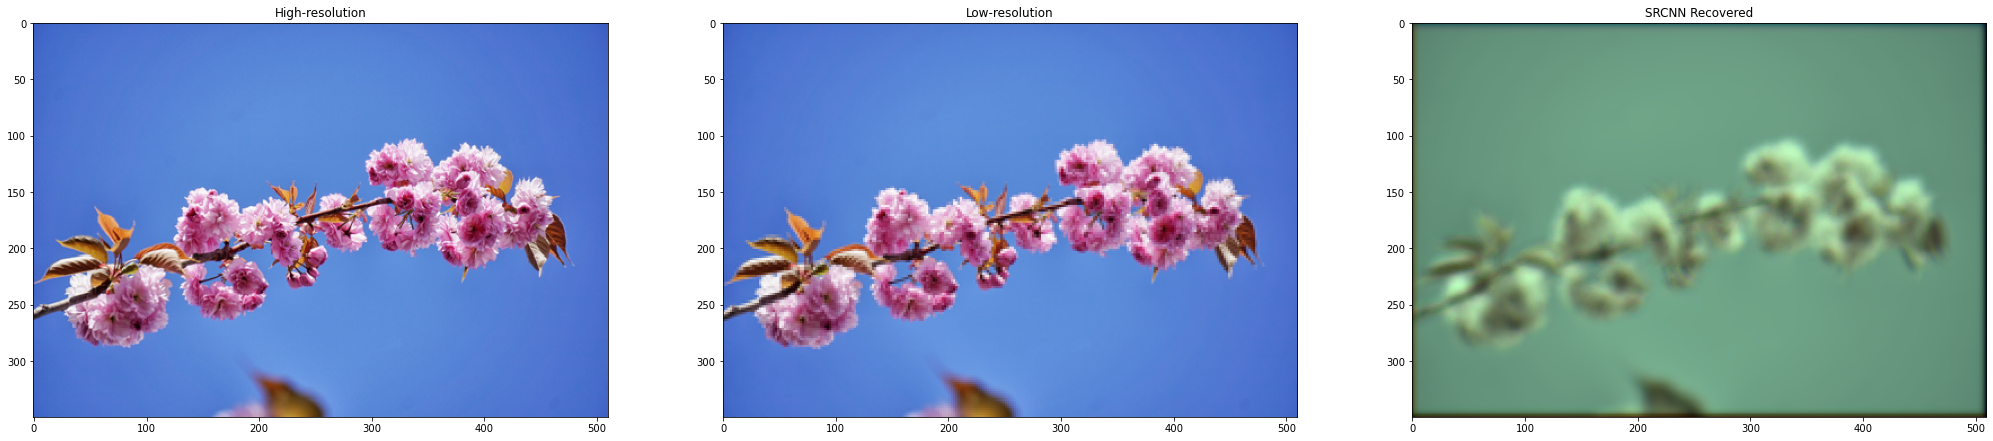

In [21]:
# Display images as subplots (Flower)

high_resolution_image_name = 'DIV2K/DIV2K_valid_LR_bicubic/X4/0898x4.png'
low_resolution_image_name = 'DIV2K/DIV2K_valid_LR_x8/0898x8.png'
if COLAB:
    low_resolution_image_name = prefix + low_resolution_image_name
    high_resolution_image_name = prefix + high_resolution_image_name

result_image_arrays = view_model_performance(high_resolution_image_name, low_resolution_image_name)
print("Low-resolution:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[1]))
print()
print("SRCNN Recovered:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[2]))

Low-resolution:
PSNR:  26.870298

SRCNN Recovered:
PSNR:  16.044788


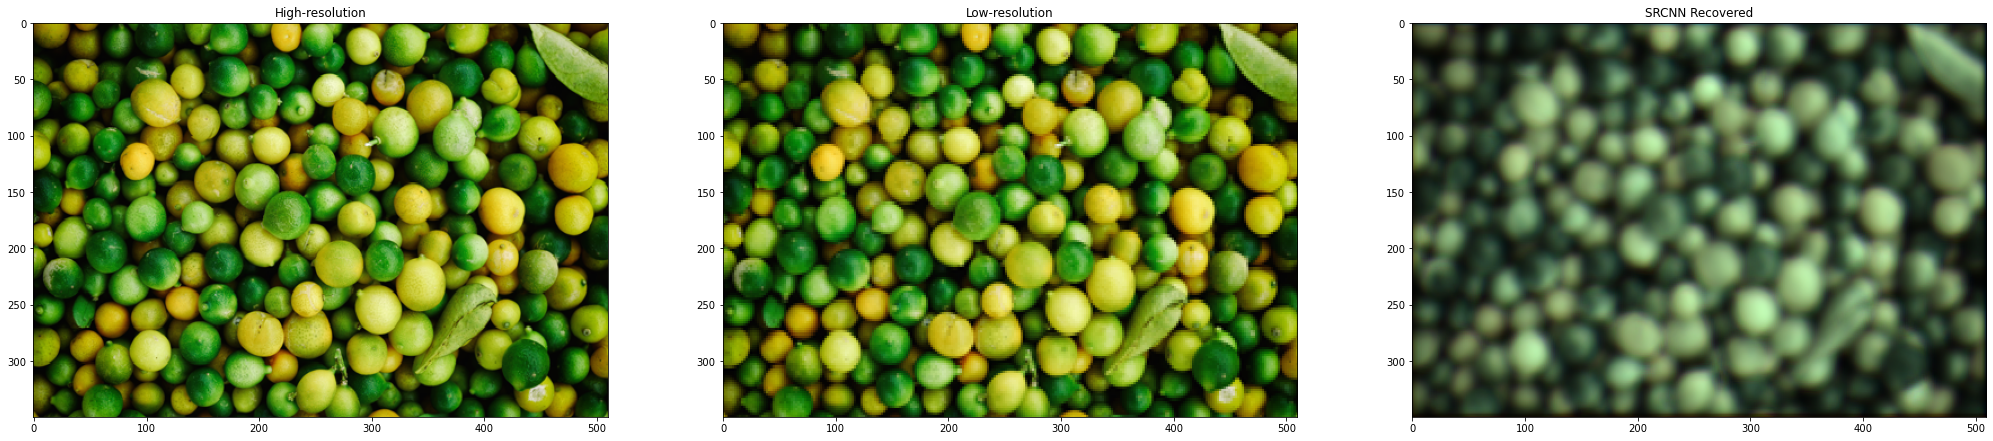

In [22]:
# Display images as subplots (Fruits) 

high_resolution_image_name = 'DIV2K/DIV2K_valid_LR_bicubic/X4/0802x4.png'
low_resolution_image_name = 'DIV2K/DIV2K_valid_LR_x8/0802x8.png'
if COLAB:
    low_resolution_image_name = prefix + low_resolution_image_name
    high_resolution_image_name = prefix + high_resolution_image_name

result_image_arrays = view_model_performance(high_resolution_image_name, low_resolution_image_name)
print("Low-resolution:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[1]))
print()
print("SRCNN Recovered:")
print("PSNR: ", calculate_image_array_PSNR(result_image_arrays[0],result_image_arrays[2]))

Original: 


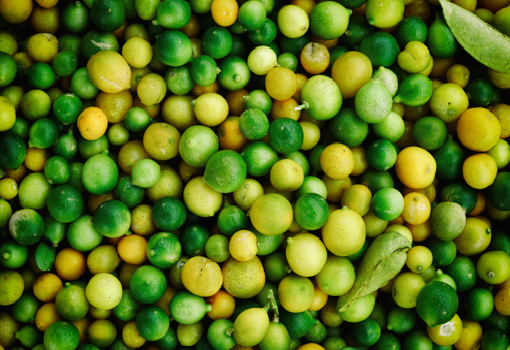

In [23]:
print_original(result_image_arrays)

Degraded: 


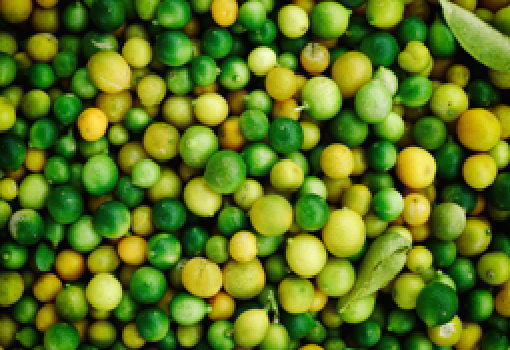

In [24]:
print_degraded(result_image_arrays)

SRCNN Recovered: 


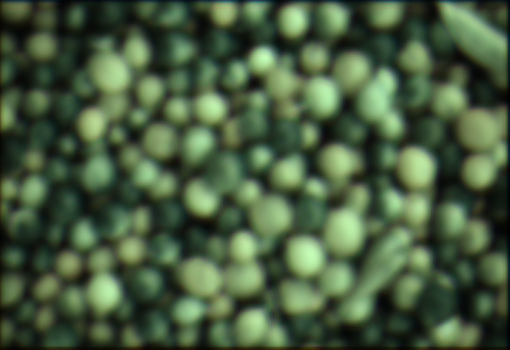

In [25]:
print_recovered(result_image_arrays)